*Exploratory Data Analysis*

# Visualizing the Training Data

In this notebook we visualize the camera poses during training.

In [1]:
import os
import subprocess
import numpy as np
import torch
import imageio
import io
import cv2

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

from run_dnerf_helpers import get_rays, to8b
from utils import load_owndataset_data
from utils import Arrow3D, draw_transformed, draw_cam

%matplotlib inline
%load_ext autoreload
%autoreload 2

DPI = 300

plt.rcParams.update({
    "font.size": 10,
    "figure.titlesize": "x-large",
    "axes.titlesize": "large",
    "axes.labelsize": "small",
    "xtick.labelsize": "small",
    "ytick.labelsize": "small",
    })

In [2]:
scene_name = "johannes"
images, depth_maps, poses, times, render_poses, render_times, hwff, i_split = load_owndataset_data(f"./data/{scene_name}", True, 1, render_pose_type="spiral")

i_train, _, _ = i_split

poses = [poses[_] for _ in i_train]
images = [images[_] for _ in i_train]

In [3]:
# xlim = [-3, 3]
# ylim = [-1, 1]
# zlim = [0, 6]
xlim = [-1., 1.]
ylim = [-1., 1.]
zlim = [-1, 1]


def series(ith_frame):
    pose = poses[ith_frame]

    fig = plt.figure(figsize=(10, 10), dpi=DPI)
    
    ax0 = fig.add_subplot(131)
    ax0.imshow(images[ith_frame])
    ax0.get_xaxis().set_visible(False)
    ax0.get_yaxis().set_visible(False)

    ax0 = fig.add_subplot(132)
    ax0.imshow(depth_maps[ith_frame])
    ax0.get_xaxis().set_visible(False)
    ax0.get_yaxis().set_visible(False)

    ax1 = fig.add_subplot(133, projection='3d')
    ax1.set_title(f"Time = {times[ith_frame]:.2f}\n")

    ax1.set_xlabel('X')
    ax1.set_xlim(*xlim)
    ax1.set_ylabel('Y')
    ax1.set_ylim(*ylim)
    ax1.set_zlabel('Z')
    ax1.set_zlim(*zlim)
    ax1.set_box_aspect((xlim[1]-xlim[0], ylim[1]-ylim[0], zlim[1]-zlim[0]))       # -> length of 1 in each dimension is visually the equal

    # The world coordinate system
    arrow_prop_dict = dict(mutation_scale=10, arrowstyle='simple', shrinkA=0, shrinkB=0)
    ax1.add_artist(Arrow3D([0, .5], [0, 0], [0, 0], **arrow_prop_dict, color='r'))
    ax1.add_artist(Arrow3D([0, 0], [0, .5], [0, 0], **arrow_prop_dict, color='b'))
    ax1.add_artist(Arrow3D([0, 0], [0, 0], [0, .5], **arrow_prop_dict, color='g'))
    ax1.text(-.1, -.1, 0.0, r'$0$')

    tcx, tcy, tcz, _ = draw_transformed(pose, ax1, linestyle="--", axes_len=0.5, mutation_scale=10)
    
    plt.legend(handles=[Line2D([0], [0], color='r', ls="--"), 
                        Line2D([0], [0], color='b', ls="--"), 
                        Line2D([0], [0], color='g', ls="--"), 
                        Line2D([0], [0], color='black', ls="-")],
            labels=["X", "Y", "Z", "Camera frustrum"], 
            title="Training view camera", 
            bbox_to_anchor=(1.15, 0.1)
            )

    # draw camera rays
    c2w = torch.Tensor(pose[:3])
    H, W, focal_x, focal_y = hwff
    i, j = torch.meshgrid(torch.linspace(0, W-1, W), torch.linspace(0, H-1, H), indexing='ij')      # shape [240, 320], [240, 320]
    i = i.t()           # pixel coordinates in X-dir
    j = j.t()           # in Y-dir
    dirs = torch.stack([(i-W*.5)/focal_x, -(j-H*.5)/focal_y, -torch.ones_like(i)], -1)                                          # shape [240, 320, 3]
    rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
    rays_o = c2w[:3,-1].expand(rays_d.shape)
    draw_cam(rays_o, rays_d, ax1, focal_dist=0.5)       # rays_o and rays_d are already in world-coordinates

    ax1.view_init(elev=45., azim=20., vertical_axis='y')        # only works with matplotlib >= 3.5
    ax1.dist = 7
        
    return fig

# inter = interact(series, ith_frame=(0, len(poses)-1, 1));

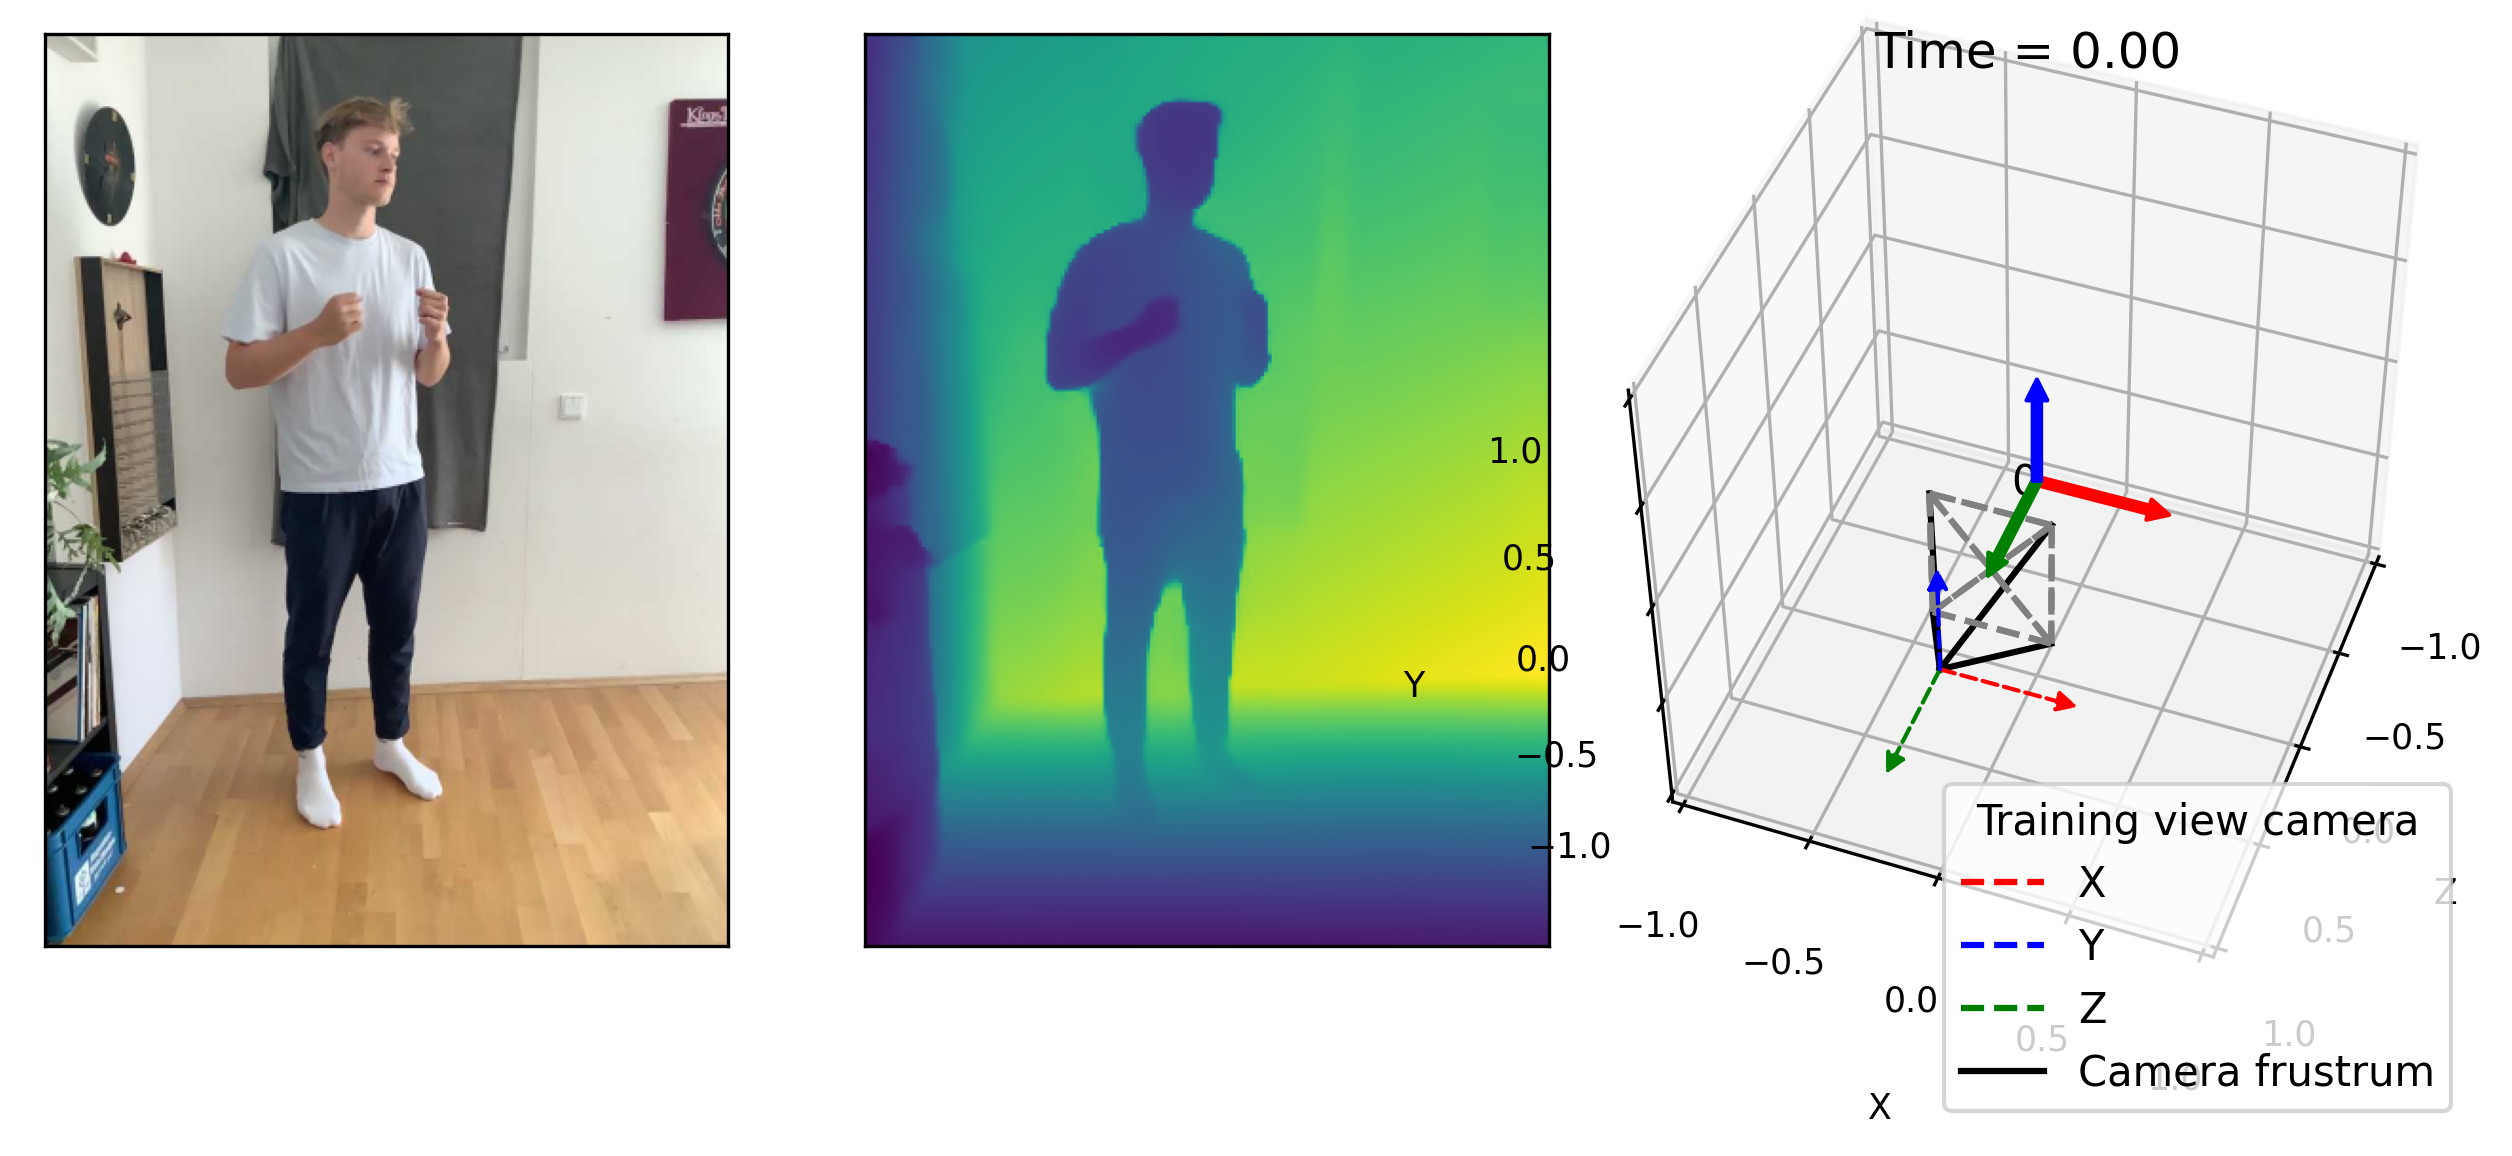

In [4]:
series(0);

Save video.

In [5]:
rgbs = []
x1 = None
for i in range(len(poses)-1):
    fig = series(i)
    fig.canvas.draw()
    plt.close()
    io_buf = io.BytesIO()
    fig.savefig(io_buf, format='raw', dpi=DPI)
    io_buf.seek(0)
    img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
                        newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
    io_buf.close()
    if not x1:
        grey = cv2.cvtColor(img_arr, cv2.COLOR_RGB2GRAY)
        thresh = cv2.threshold(grey,226,255,cv2.THRESH_BINARY)[1]
        binary = cv2.bitwise_not(thresh)

        x1,y1,w,h = cv2.boundingRect(binary)
        x2 = x1+w
        y2 = y1+h

    rgbs.append(img_arr[y1:y2, x1:x2])

imageio.mimwrite('train_frames_w_poses.mp4', np.array(rgbs, dtype=np.uint8), fps=10, quality=8)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2438, 1097) to (2448, 1104) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x597ec80] Warning: data is not aligned! This can lead to a speed loss
